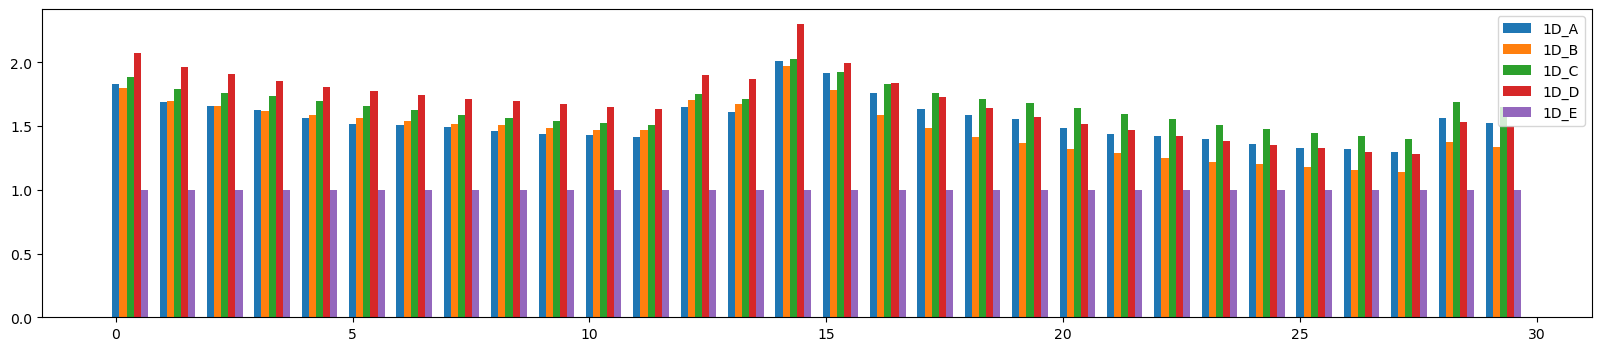

In [2]:
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
def load_data_to_tensor(file_path):
	data_list = []
	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(r'bs=(\d+)\s*, dimX=(\d+)\s*, DY=(\d+)\s*, N=(\d+)\s*, K=(\d+)\s*, TIME=\s*([\d.]+)ms', line)
			if match:
				bs, dimX, DY, N, K, time = map(float, match.groups())
				data_list.append([bs, dimX, DY, N, K, time])
	tensor_data = torch.tensor(data_list, dtype=torch.float32)
	return tensor_data

file_path = [
			'exp_data/1D_A', 
			'exp_data/1D_B', 
			'exp_data/1D_C', 
			'exp_data/1D_D', 
			'exp_data/1D_E']
data = []
plt.figure(figsize=(20, 4))

for file in file_path:
	data.append(load_data_to_tensor(file))
samples =30
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][:, -1] / data[0][:, -1]
	plt.bar(x + cnt * bar_width, data[-1][-samples:, -1] / data[i][-samples:, -1], width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')
# for i in range(1, len(performance_ratio)):
# 	if performance_ratio[i] > 1.6:
# 		print(data[0][i], data[1][i, -1])
# 	# print(performance_ratio[i])

In [38]:
import torch

# 假设 data[-2] 和 data[0] 都是 [15, 2, 2, 16, 6] 的 tensor
time_ratio = data[3][..., -1] / data[0][..., -1]  # shape: [15, 2, 2, 16]
# print(time_ratio.shape)  # [15, 2, 2, 16]
# Step 1: flatten
flat_ratio = time_ratio.flatten()  # shape: [15*2*2*16] = [960]

# Step 2: 构建原始 index 坐标
indices = torch.cartesian_prod(
    torch.arange(15),
    torch.arange(2),
    torch.arange(2),
    torch.arange(16)
)  # shape: [960, 4] 代表每一个 [bs, dimX, dimY, N]

# Step 3: 排序
sorted_values, sorted_idx = torch.sort(flat_ratio)

# 得到排序后的 index
sorted_indices = indices[sorted_idx]  # shape: [960, 4]
print(len(sorted_indices))

# Step 4: 输出排序后的配置和对应比值
for i in range(960):  # 前10项
    bs, dimX, dimY, N = sorted_indices[i].tolist()
    ratio = sorted_values[i].item()
    print(f"[bs={bs}, dimX={dimX}, dimY={dimY}, N={N}] -> ratio={ratio:.4f} speedup={1/ratio:.4f}x")


960
[bs=5, dimX=0, dimY=1, N=0] -> ratio=0.7576 speedup=1.3200x
[bs=6, dimX=0, dimY=0, N=0] -> ratio=0.8125 speedup=1.2308x
[bs=5, dimX=0, dimY=1, N=1] -> ratio=0.8333 speedup=1.2000x
[bs=5, dimX=1, dimY=1, N=0] -> ratio=0.8333 speedup=1.2000x
[bs=14, dimX=1, dimY=0, N=0] -> ratio=0.8476 speedup=1.1799x
[bs=10, dimX=1, dimY=0, N=0] -> ratio=0.8517 speedup=1.1741x
[bs=7, dimX=0, dimY=0, N=6] -> ratio=0.8556 speedup=1.1688x
[bs=14, dimX=1, dimY=0, N=7] -> ratio=0.8556 speedup=1.1688x
[bs=6, dimX=0, dimY=0, N=1] -> ratio=0.8571 speedup=1.1667x
[bs=9, dimX=1, dimY=0, N=3] -> ratio=0.8571 speedup=1.1667x
[bs=9, dimX=1, dimY=0, N=4] -> ratio=0.8571 speedup=1.1667x
[bs=14, dimX=1, dimY=0, N=11] -> ratio=0.8586 speedup=1.1647x
[bs=14, dimX=1, dimY=0, N=3] -> ratio=0.8592 speedup=1.1639x
[bs=14, dimX=1, dimY=0, N=15] -> ratio=0.8598 speedup=1.1631x
[bs=12, dimX=1, dimY=0, N=0] -> ratio=0.8605 speedup=1.1621x
[bs=14, dimX=1, dimY=0, N=10] -> ratio=0.8608 speedup=1.1616x
[bs=6, dimX=1, dimY=0, N=

In [4]:
import torch

# 假设 data[-2] 和 data[0] 都是 [15, 2, 2, 16, 6] 的 tensor
target = 0
time_ratio = data[0][..., -1] / data[target][..., -1]  # shape: [15, 2, 2, 16]
time_ratio_1 = data[1][..., -1] / data[target][..., -1]  # shape: [15, 2, 2, 16]
time_ratio_2 = data[2][..., -1] / data[target][..., -1]  # shape: [15, 2, 2, 16]
time_ratio_3 = data[3][..., -1] / data[target][..., -1]  # shape: [15, 2, 2, 16]
print(time_ratio.shape)  # [15, 2, 2, 16]
# assert 0
stacked = torch.stack([time_ratio, time_ratio_1, time_ratio_2, time_ratio_3], dim=0)  # shape: [4, 2176]

# 取最大值和对应索引
time_ratio, min_index = torch.min(stacked, dim=0)  # shape: [2176] each

# print(time_ratio.shape)  # [15, 2, 2, 16]
# Step 1: flatten
data_size = data[3][..., :-1]
# 假设 time_ratio 和 data_size 都是 numpy 数组，且 shape 都是 [15, 2, 2, 16]
import numpy as np

# Flatten 两个数组为一维
keys = time_ratio.flatten()
values = data_size.reshape(-1, data_size.shape[-1])  # shape: [N, M], M = data_size 的最后一个维度

# 创建 key-value 对并排序
sorted_map = sorted(zip(keys, values), key=lambda x: x[0])

# 转为字典（注意：若 key 重复会被覆盖）
sorted_dict = dict(sorted_map)

# 或者如果你希望保留所有重复 key，可以使用 list:
from collections import defaultdict
data_dim_name = ['bs', 'dimX', 'DY', 'N', 'K']

sorted_dict_list = defaultdict(list)
for k, v in sorted_map:
    sorted_dict_list[k].append(v)
for k, v in sorted_dict_list.items():
    for i in range(5):

        print(f"{data_dim_name[i]}: ={int(v[0][i].item()):<10}", end='')
    print(f"Time Ratio: ={k:<10.2f}", end='')
    print(f"SpeedUP: ={1 / k:<10.2f}", end='')
    print('')
    # print(v)

torch.Size([960])
bs: =32        dimX: =1         DY: =128       N: =128       K: =8         Time Ratio: =0.76      SpeedUP: =1.32      
bs: =64        dimX: =1         DY: =128       N: =64        K: =8         Time Ratio: =0.81      SpeedUP: =1.23      
bs: =32        dimX: =1         DY: =128       N: =128       K: =16        Time Ratio: =0.83      SpeedUP: =1.20      
bs: =32        dimX: =1         DY: =256       N: =128       K: =8         Time Ratio: =0.83      SpeedUP: =1.20      
bs: =32768     dimX: =1         DY: =256       N: =64        K: =8         Time Ratio: =0.85      SpeedUP: =1.18      
bs: =1024      dimX: =1         DY: =256       N: =64        K: =8         Time Ratio: =0.85      SpeedUP: =1.17      
bs: =1         dimX: =1         DY: =128       N: =128       K: =8         Time Ratio: =0.85      SpeedUP: =1.17      
bs: =2         dimX: =1         DY: =128       N: =128       K: =8         Time Ratio: =0.85      SpeedUP: =1.17      
bs: =4         dimX: =1       

torch.Size([1, 2, 16])
torch.Size([1, 2, 16])
torch.Size([1, 2, 16])
torch.Size([1, 2, 16])
torch.Size([1, 2, 16])


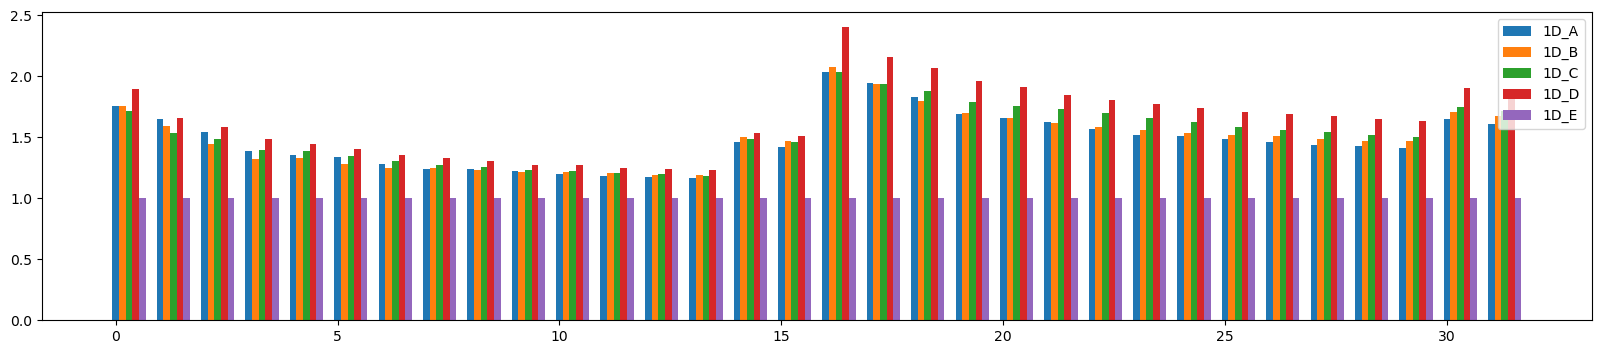

In [2]:
import torch
import numpy as np
import re
import matplotlib.pyplot as plt


import torch
import re
import numpy as np

def load_data_to_tensor(file_path):
    # 读取数据
    data_list = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(r'bs=(\d+)\s*, dimX=(\d+)\s*, DY=(\d+)\s*, N=(\d+)\s*, K=(\d+)\s*, TIME=\s*([\d.]+)ms', line)
            if match:
                bs, dimX, DY, N, K, time = map(float, match.groups())
                data_list.append([bs, dimX, DY, N, K, time])

    # 转换为 PyTorch Tensor
    data_array = np.array(data_list)  # shape: (N, 6)

    # 提取唯一值，确定 Tensor 形状
    bs_vals = np.unique(data_array[:, 0])
    dimX_vals = np.unique(data_array[:, 1])
    DY_vals = np.unique(data_array[:, 2])
    N_vals = np.unique(data_array[:, 3])
    K_vals = np.unique(data_array[:, 4])

    # 创建 5D Tensor，并初始化为 NaN
    tensor_shape = (len(bs_vals), len(dimX_vals), len(DY_vals), len(N_vals), len(K_vals))
    tensor_data = torch.full(tensor_shape, float('nan'), dtype=torch.float32)

    # 映射参数值到索引
    def get_index(val, arr):
        return np.where(arr == val)[0][0]

    # 填充数据
    for row in data_array:
        bs_idx = get_index(row[0], bs_vals)
        dimX_idx = get_index(row[1], dimX_vals)
        DY_idx = get_index(row[2], DY_vals)
        N_idx = get_index(row[3], N_vals)
        K_idx = get_index(row[4], K_vals)
        tensor_data[bs_idx, dimX_idx, DY_idx, N_idx, K_idx] = row[5]  # 存 TIME

    return tensor_data, bs_vals, dimX_vals, DY_vals, N_vals, K_vals

file_path = [
			'exp_data/1D_A', 
			'exp_data/1D_B', 
			'exp_data/1D_C', 
			'exp_data/1D_D', 
			'exp_data/1D_E']
data = []
plt.figure(figsize=(20, 4))

for file in file_path:
	tensor_data, bs_vals, dimX_vals, DY_vals, N_vals, K_vals = load_data_to_tensor(file)
	data.append(tensor_data)
samples = data[0][-1,  :, :, 0, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, :, :, 0, :] / data[i][-1,  :, :, 0, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')
# for i in range(1, len(performance_ratio)):
# 	if performance_ratio[i] > 1.6:
# 		print(data[0][i], data[1][i, -1])
# 	# print(performance_ratio[i])

torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])


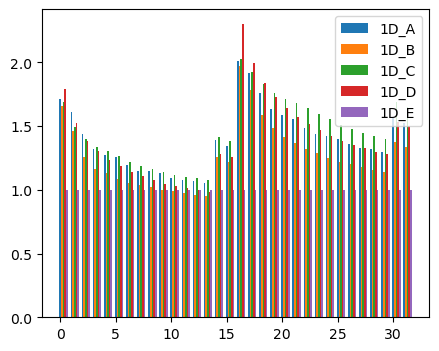

In [3]:
plt.figure(figsize=(5, 4))
samples = data[0][-1,  -1, :, 1, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, -1, :, 1, :] / data[i][-1,  -1, :, 1, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')

torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])


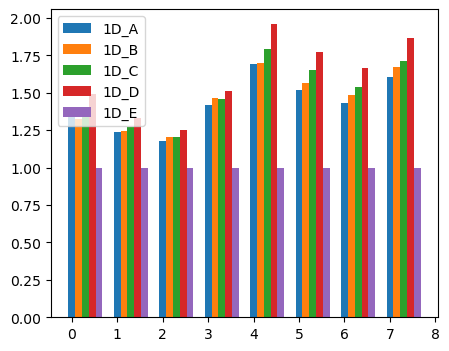

In [49]:
plt.figure(figsize=(5, 4))
samples = data[0][-1,  -1, :, 0, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, -1, :, 0, :] / data[i][-1,  -1, :, 0, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')

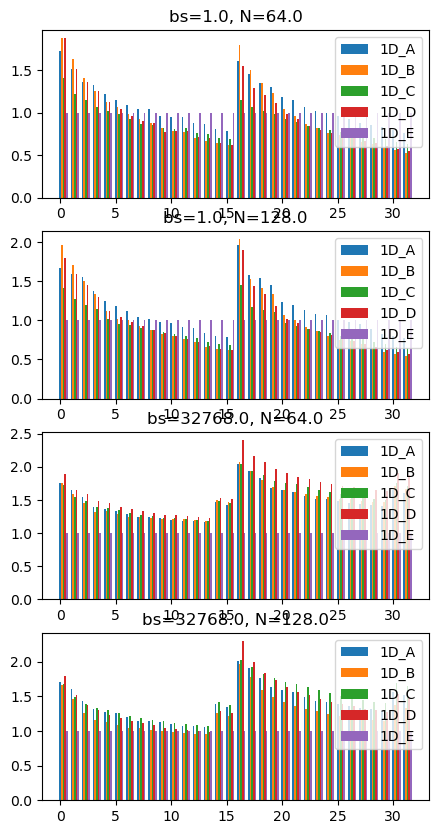

In [4]:
fig, ax = plt.subplots(figsize=(5, 10), nrows = 4)
bs_id = 0
N_id = 0
samples = data[0][bs_id,  -1, :, N_id, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
fig_id = 0
for bs_id in [0, -1]:
	for N_id in [0, -1]:
		cnt = 0
		for i in range(len(data)):
			performance_ratio =  data[-1][bs_id, -1, :, N_id, :] / data[i][bs_id,  -1, :, N_id, :]
			# print(performance_ratio.shape)
			# assert 0
			ax[fig_id].bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
			cnt += 1
		ax[fig_id].legend()
		ax[fig_id].set_title(f'bs={bs_vals[bs_id]}, N={N_vals[N_id]}')
		fig_id += 1
		# plt.savefig('1D.pdf')